In [562]:
# All imports here
import os
import librosa
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import svm
import sklearn
import keras
from keras.utils import np_utils
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import models,regularizers
from tensorflow.keras import layers
%matplotlib inline
#pip install libav-tools

In [101]:
def create_df(filePath, label):
    fileList = os.listdir(filePath)
    df_obj = pd.DataFrame(fileList)
    # Adding label original to the dataframe to represent original
    df_obj['label'] = label
    df_obj = df_obj.rename(columns={0:'file'})
    df_obj['path'] = filePath
    return df_obj

In [102]:
# Create lists of the files
#fileList1 = os.listdir('recordings/original-recordings')
#df_original = pd.DataFrame(fileList1)
# Adding label original to the dataframe to represent original
#df_original['label'] = 'original'
# Renaming the column
#df_original = df_original.rename(columns={0:'file'})
#df_original

In [103]:
filePaths = ['recordings/original-recordings', 'recordings/speaker-1-desktop-speakers', 'recordings/speaker-2-soundbox', 'recordings/speaker-3-LG_soundbar', 'recordings/speaker-4-Phillips-tv']

pathsAndLabels = {'original': 'recordings/original-recordings', 'desktop': 'recordings/speaker-1-desktop-speakers',
                 'soundbox': 'recordings/speaker-2-soundbox', 'soundbar': 'recordings/speaker-3-LG_soundbar', 'tv': 'recordings/speaker-4-Phillips-tv'}

#filePaths = ['wav-recordings/original_recordings']
#pathsAndLabels = {'original': 'wav-recordings/original_recordings'}

In [104]:
dataFrames = [] #Empty list for storing the datatframes

for label, path in pathsAndLabels.items(): # Loop for iterating through the paths and labels and creating the dataframes
    dataFrames.append(create_df(path, label))
    print(label, path)

for i in range(len(dataFrames)):
    print(dataFrames[i])
#print(dataFrames[5])

original recordings/original-recordings
desktop recordings/speaker-1-desktop-speakers
soundbox recordings/speaker-2-soundbox
soundbar recordings/speaker-3-LG_soundbar
tv recordings/speaker-4-Phillips-tv
                    file     label                            path
0    Innspilling (1).m4a  original  recordings/original-recordings
1   Innspilling (10).m4a  original  recordings/original-recordings
2   Innspilling (11).m4a  original  recordings/original-recordings
3   Innspilling (12).m4a  original  recordings/original-recordings
4   Innspilling (13).m4a  original  recordings/original-recordings
5   Innspilling (14).m4a  original  recordings/original-recordings
6   Innspilling (15).m4a  original  recordings/original-recordings
7   Innspilling (16).m4a  original  recordings/original-recordings
8   Innspilling (17).m4a  original  recordings/original-recordings
9   Innspilling (18).m4a  original  recordings/original-recordings
10  Innspilling (19).m4a  original  recordings/original-reco

In [105]:
# Concatenating all the dataframes into a single one
df = pd.concat(dataFrames, ignore_index=True)

# Loop for renaming the files based on label (This is just done for keeping easier track of dataframes)
#for i in range(len(df)):
    #if df['label'][i] == 'original':
    #    df['file'][i] =  str(0) + df['file'][i]
    #elif df['label'][i] == 'desktop':
    #    df['file'][i] =  str(1) + df['file'][i]
    #elif df['label'][i] == 'soundbox':
    #    df['file'][i] =  str(2) + df['file'][i]
    #elif df['label'][i] == 'soundbar':
    #    df['file'][i] =  str(3) + df['file'][i]
    #else:
    #    df['file'][i] =  str(4) + df['file'][i]
#    df['file'][i] =  str(i) + df['file'][i]
    #print(df['path'][i])

print(df[40:100])

                    file     label                                   path
40  Innspilling (46).m4a  original         recordings/original-recordings
41  Innspilling (47).m4a  original         recordings/original-recordings
42  Innspilling (48).m4a  original         recordings/original-recordings
43  Innspilling (49).m4a  original         recordings/original-recordings
44   Innspilling (5).m4a  original         recordings/original-recordings
45  Innspilling (50).m4a  original         recordings/original-recordings
46   Innspilling (6).m4a  original         recordings/original-recordings
47   Innspilling (7).m4a  original         recordings/original-recordings
48   Innspilling (8).m4a  original         recordings/original-recordings
49   Innspilling (9).m4a  original         recordings/original-recordings
50   Innspilling (1).m4a   desktop  recordings/speaker-1-desktop-speakers
51  Innspilling (10).m4a   desktop  recordings/speaker-1-desktop-speakers
52  Innspilling (11).m4a   desktop  re

In [106]:
#df_copy = df.copy()
#print(df_copy[:60])

# Splitting into test and train data. First randomizing the dataframe containing every sample
df = df.sample(frac=1).reset_index(drop=True)

# Creating a training dataset with 70% of the data
train_df = df.sample(frac=0.7)

# Taking the remaining after the 70 split and putting them into the test datatset
test_df = df.drop(train_df.index)

print(len(test_df))
print(len(train_df))
print(train_df[:60])
print(test_df[:60])


75
175
                     file     label                                   path
87   Innspilling (36).m4a  soundbox          recordings/speaker-2-soundbox
64   Innspilling (26).m4a  original         recordings/original-recordings
144  Innspilling (25).m4a  soundbox          recordings/speaker-2-soundbox
212  Innspilling (44).m4a  soundbox          recordings/speaker-2-soundbox
244  Innspilling (48).m4a  original         recordings/original-recordings
10   Innspilling (17).m4a  soundbox          recordings/speaker-2-soundbox
247   Innspilling (2).m4a  original         recordings/original-recordings
72   Innspilling (21).m4a   desktop  recordings/speaker-1-desktop-speakers
132  Innspilling (37).m4a        tv       recordings/speaker-4-Phillips-tv
239  Innspilling (23).m4a   desktop  recordings/speaker-1-desktop-speakers
205  Innspilling (29).m4a   desktop  recordings/speaker-1-desktop-speakers
120  Innspilling (15).m4a  soundbar       recordings/speaker-3-LG_soundbar
70   Innspilling (

In [107]:
# Checking that the splits have a reasonably balanced amount of different labels
train_df['label'].value_counts(normalize=True)

soundbox    0.228571
desktop     0.211429
original    0.188571
tv          0.188571
soundbar    0.182857
Name: label, dtype: float64

In [108]:
test_df['label'].value_counts(normalize=True)

soundbar    0.240000
tv          0.226667
original    0.226667
desktop     0.173333
soundbox    0.133333
Name: label, dtype: float64

In [109]:
# The splits have about equal amounts and we decide to leave it at this

In [156]:
# Function for extracting the mffcs which we will use as features for the task
# Most of this function is inspired by and based upon https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/ in nr # in our appendix

def feature_extract(row):
    # Getting the full path
    #fileName = os.path.abspath(row.path)
    fileName = row.path + '/' + row.file
    print('fileName: ', fileName)
    #print(row.path)

    # Loading the file as floating point time series
    X, sample_rate = librosa.load(fileName, res_type='kaiser_fast')

    # Generate MFCCs from the time series
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    feature = mfccs
    label = row.label

    return [feature, label]
    #return [fileName]

tempTrain = train_df.apply(feature_extract, axis=1) # Our new df holding the data with extracted features
print(tempTrain[:10])
#tempTrain.columns = ['feature', 'label']

print("TESTDATA")

tempTest = test_df.apply(feature_extract, axis=1)
print(tempTest[:10])

fileName:  recordings/speaker-2-soundbox/Innspilling (36).m4a
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
fileName:  recordings/original-recordings/Innspilling (26).m4a
fileName:  recordings/speaker-2-soundbox/Innspilling (25).m4a
fileName:  recordings/speaker-2-soundbox/Innspilling (44).m4a
fileName:  recordings/original-recordings/Innspilling (48).m4a
fileName:  recordings/speaker-2-soundbox/Innspilling (17).m4a
fileName:  recordings/original-recordings/Innspilling (2).m4a
fileName:  recordings/speaker-1-desktop-speakers/Innspilling (21).m4a
fileName:  recordings/speaker-4-Phillips-tv/Innspilling (37).m4a
fileName:  recordings/speaker-1-desktop-speakers/Innspilling (23).m4a
fileName:  recordings/speaker-1-desktop-speakers/Innspilling (29).m4a
fileName:  recordings/speaker-3-LG_soundbar/Innspilling (15).m4a
fileName:  recordings/speaker-

In [534]:
from IPython.core.interactiveshell import InteractiveShell
pd.options.display.max_seq_items = 2000
InteractiveShell.ast_node_interactivity = "all"
#print(tempTrain[:10])
#print(tempTest[:10])
#tempTrain.columns = ['feature', 'label']
#print(tempTrain.feature)
#print(tempTrain[:1])
print(tempTrain[1])
print(tempTrain.shape)

[array([-5.8244519e+02,  3.3751541e+01, -2.9314611e+00,  1.9375320e+01,
        1.4941488e+01,  1.5271160e+01, -1.7403244e+01,  1.3424093e+01,
       -1.8310944e+01,  1.7173058e+01, -1.3790832e+01,  9.7407608e+00,
       -1.6223175e+01,  8.8342590e+00, -1.7392017e+01,  5.2525172e+00,
       -9.0834160e+00, -7.2900021e-01, -6.6283269e+00, -1.0978609e+00,
       -1.4038672e+01,  3.7755237e+00, -6.5798378e+00, -1.9910828e+00,
       -6.3818483e+00,  5.7531780e-01, -4.6610479e+00, -2.2160501e+00,
       -1.0894939e+00,  2.8782287e-01, -5.7042475e+00, -2.4247012e+00,
       -2.8886049e+00, -1.0849324e+00,  3.3872786e-01, -4.4524384e-01,
       -5.2054753e+00, -1.6147156e+00, -4.6504602e+00, -2.2764251e+00],
      dtype=float32), 'soundbar']
(175,)


In [162]:
# Creating our feature vector X and our target vector y
#X_train = np(tempTrain.feature.tolist())

In [428]:
# Creating our feature matrix and target vector for the training and test set
X_train = []
y_train = []
for obj in tempTrain:
    #print(obj)
    X_train.append(obj[0])
    y_train.append(obj[1])

X_test = []
y_test = []
for obj in tempTest:
    print(obj)
    X_test.append(obj[0])
    y_test.append(obj[1])
#for obj in tempTrain:
#    print(obj)


[array([-4.98735687e+02,  7.29769669e+01, -7.63189840e+00,  2.15344963e+01,
        1.01189871e+01,  8.70023251e+00, -1.69920158e+01,  5.68006372e+00,
       -1.37542305e+01,  7.32722521e+00, -1.17701950e+01,  9.64634478e-01,
       -1.15434036e+01,  6.78404197e-02, -9.14878082e+00,  2.54599190e+00,
       -8.90166187e+00, -5.19858694e+00, -2.80854392e+00, -1.79771066e+00,
       -1.04671745e+01,  1.60132796e-02, -3.85705662e+00, -2.46077323e+00,
       -1.47261214e+00, -3.00321269e+00, -9.30453718e-01, -3.78773642e+00,
       -6.39797270e-01, -1.43419647e+00, -1.20994496e+00, -3.75134015e+00,
       -1.77742100e+00, -3.20055628e+00,  8.63250852e-01, -3.18253350e+00,
       -3.55127978e+00, -2.72077608e+00, -2.10028028e+00, -5.57580113e-01],
      dtype=float32), 'original']
[array([-5.8013715e+02,  3.1240751e+01, -9.1783686e+00,  2.6718287e+01,
        1.7296877e+01,  1.0443140e+01, -1.6949547e+01,  1.5332540e+01,
       -2.3931429e+01,  2.1849934e+01, -1.3356496e+01,  5.4458184e+00,


In [429]:
# Making separate target arrays for sklearn and keras frameworks, as they work on different target
print(y_train)
print(y_test)

# Creating the target vector for the conventional machine learning algorithms in sklearn which expect integer arrays. Creating an empty list for this
y_train_cl = []
for label in y_train:
    if label == 'original':
        y_train_cl.append(0)
    elif label == 'desktop':
        y_train_cl.append(1)
    elif label == 'soundbox':
        y_train_cl.append(2)
    elif label == 'soundbar':
        y_train_cl.append(3)
    else:
        y_train_cl.append(4)
print(y_train_cl)

# Doing the same thing as above for the test vector
y_test_cl = []
for label in y_test:
    if label == 'original':
        y_test_cl.append(0)
    elif label == 'desktop':
        y_test_cl.append(1)
    elif label == 'soundbox':
        y_test_cl.append(2)
    elif label == 'soundbar':
        y_test_cl.append(3)
    else:
        y_test_cl.append(4)
print(y_test_cl)


['soundbox', 'original', 'soundbox', 'soundbox', 'original', 'soundbox', 'original', 'desktop', 'tv', 'desktop', 'desktop', 'soundbar', 'tv', 'soundbar', 'tv', 'soundbar', 'tv', 'soundbox', 'desktop', 'soundbox', 'desktop', 'desktop', 'tv', 'desktop', 'soundbox', 'soundbox', 'soundbar', 'original', 'tv', 'original', 'tv', 'original', 'original', 'desktop', 'desktop', 'original', 'soundbar', 'tv', 'soundbar', 'tv', 'original', 'tv', 'soundbox', 'soundbox', 'soundbar', 'soundbar', 'tv', 'desktop', 'desktop', 'soundbar', 'original', 'original', 'soundbox', 'original', 'soundbar', 'soundbox', 'tv', 'original', 'tv', 'original', 'soundbox', 'original', 'soundbox', 'soundbar', 'original', 'soundbox', 'tv', 'soundbox', 'soundbox', 'desktop', 'soundbar', 'tv', 'soundbar', 'desktop', 'soundbar', 'soundbox', 'soundbox', 'soundbar', 'original', 'soundbar', 'soundbox', 'soundbox', 'tv', 'desktop', 'tv', 'tv', 'soundbar', 'soundbox', 'soundbox', 'soundbar', 'soundbox', 'tv', 'tv', 'desktop', 'sound

In [430]:
#print(X_train[1])
#print(y_train)

#X_train = np.array(X_train)
#y_train = np.array(y_train)
#
#X_test = np.array(X_test)
#y_test = np.array(y_test)
#
#print(X_train.shape)
#print(X_test.shape)

# Making separate target arrays for sklearn and keras frameworks, as they work on different target

# Hot encoding y for keras, as keras doesn't use integer target arrays like sklearn
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))

y_test = np_utils.to_categorical(lb.fit_transform(y_test))
print(y_train[0])
print(y_test[0])
print(y_train)

[0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0.]
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0

In [431]:
# Converting the training features and test features to a numpy array 
X_train = np.array(X_train)
#y_train = np.array(y_train)

X_test = np.array(X_test)
#y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)

# Hot encoding y
#lb = LabelEncoder()
#y_train = np_utils.to_categorical(lb.fit_transform(y_train))
#
#y_test = np_utils.to_categorical(lb.fit_transform(y_test))

(175, 40)
(75, 40)


In [432]:
# Standardizing the features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(X_train[:3])
print(y_train[:5])

[[-0.02216797 -0.65377766 -1.1283584  -0.08740792  0.7500985  -0.5173679
  -0.33471087 -0.81130475 -0.07260235 -1.9200822   2.5425377  -1.3213586
  -0.2900435   0.33859482  1.1149688  -1.8887362   1.6214136  -0.21470794
   0.6123977  -1.0631332   0.4353835  -1.7965643  -0.077767   -1.0482727
   1.6157397   0.35603774  0.73579544 -0.50742984  1.9227425   0.86047953
   0.78126884  1.0224851   0.7210926   0.4103991   1.379354   -0.11019032
  -0.10054046  0.65645504  1.3119762  -0.03880136]
 [ 1.6182622   1.5776995   0.43024495  1.4559005   0.88490546  0.40507892
   0.12554614 -0.48783082  0.8673117   0.3328651  -1.2951367  -0.7688018
   0.47917658 -0.9576071   0.55708456  0.28785235  0.09618106 -0.93330556
  -0.33103362 -0.29312798  0.53025454  0.18935956  0.11856648 -0.4153535
  -0.14808135 -1.1725885   0.03496121 -1.0538017  -0.70979184 -2.7350361
   0.68006057 -0.3046199   0.6582387  -0.95868033 -2.2060194  -0.8928952
   0.71287024  0.13415752  0.10192142 -0.53524965]
 [ 0.27742356 -0.

# The conventional machine learning algorithm we chose for this task was the Support Vector Machine
The reasoning behind this was first of all that our problem was a classification problem, and SVM can do both classification and regression.
We figured that since the SVM allows us to specify the kernels, and then find an optimal boundary in between these resulting outputs, that it would be the best at separating our data and getting the labels right.

We decided upon testing four different kernel functions for this conventional implementation to see if there was any difference. The theory behind
being that the linear would perform the "best" of them. This being because the number of features in the problem were larger than the number of samples, and that the data was fairly "simple". We also hypothesized that the different models would all easily distinguish between the recordings of the different speakers, seeing as there were clear differences to the naked ear in regards to both volume and perception. With this meaning that the way one would describe sound as a human, the way we percieve it, it was very distinctive and seeing as we used MFCCs, which use Mel scaling to try and model the way a human would hear, our theory was that our models would perform extremely and unrealistically well.

Our implementation of the SVM with different kernels are below, inspired by the multiclass_svm.py lab material and https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02

In [433]:
# Converting the test data integer arrays
y_test_cl = np.array(y_test_cl)
y_train_cl = np.array(y_train_cl)

# The linear SVM
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train_cl)

# The Radial basis function kernel
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train_cl)

# The Polynomial kernel
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train_cl)

# The sigmoid kernel
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train_cl)

### Evaluating the models

In [434]:
# Making the predictions
linear.pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)

# Measuring the accuracy 
accuracy_lin = linear.score(X_test, y_test_cl)
accuracy_poly = poly.score(X_test, y_test_cl)
accuracy_rbf = rbf.score(X_test, y_test_cl)
accuracy_sig = sig.score(X_test, y_test_cl)

print('Accuracy Linear Kernel:', accuracy_lin)
print('Accuracy Polynomial Kernel:', accuracy_poly)
print('Accuracy Radial Basis Kernel:', accuracy_rbf)
print('Accuracy Sigmoid Kernel:', accuracy_sig)

Accuracy Linear Kernel: 1.0
Accuracy Polynomial Kernel: 1.0
Accuracy Radial Basis Kernel: 0.13333333333333333
Accuracy Sigmoid Kernel: 1.0


In [443]:
# Calculating the F1 score
from sklearn.metrics import f1_score

f1_lin = f1_score(y_test_cl, linear_pred, average='macro')
f1_poly = f1_score(y_test_cl, poly_pred, average='macro')
f1_rbf = f1_score(y_test_cl, rbf_pred, average='macro')
f1_sig = f1_score(y_test_cl, sig_pred, average='macro')

print('precision linear: ', f1_lin)
print('precision polynomial: ', f1_poly)
print('precision radial basis function: ', f1_rbf)
print('precision sigmoid: ', f1_sig)

precision linear:  1.0
precision polynomial:  1.0
precision radial basis function:  0.047058823529411764
precision sigmoid:  1.0


In [437]:
# creating a confusion matrix for all the kernels
cm_lin = confusion_matrix(y_test_cl, linear_pred)
cm_poly = confusion_matrix(y_test_cl, poly_pred)
cm_rbf = confusion_matrix(y_test_cl, rbf_pred)
cm_sig = confusion_matrix(y_test_cl, sig_pred)
print(cm_lin)
print(cm_poly)
print(cm_rbf)
print(cm_sig)

[[17  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 18  0]
 [ 0  0  0  0 17]]
[[17  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 18  0]
 [ 0  0  0  0 17]]
[[ 0  0 17  0  0]
 [ 0  0 13  0  0]
 [ 0  0 10  0  0]
 [ 0  0 18  0  0]
 [ 0  0 17  0  0]]
[[17  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 18  0]
 [ 0  0  0  0 17]]


### What we see here
is that the linear, polynomial and sigmoid kernels all had 100% accuracy, while the radial basis function only managed 0.13%, and also had a bad F1 score. It classified everything as the 'soundbox' label. Our theory regarding the rbf kernel is as previous stated, that the number of features are larger than the number of instances.

Our main theory for why the other had such high scores is that our dataset is very "clean" and is relatively small also. As previously stated it was easy to classify the different speakers using nothing but our human perception. We think that if we had a larger and messier dataset, we would not have seen 100% accuracy as we are seeing now. 

# Deep learning
For this next section we will use a vanilla CNN model to perform the exact same measures that we did with the support vector machines and
compare the performances. Our theory now points in the direction of the CNN performing worse than the SVM because of the small size of the dataset, but we are not completely sure about this, seeing as the data is also easily classifiable

## As specified in the assignment text, we are to use a vanilla CNN model for the classification. This is very tricky because the CNN expects an image

In [555]:
print(X_test.shape)

(75, 40)


In [556]:
print(X_train.shape)
#print(X_train[:4])
X_train_rs = X_train.reshape(np.append(X_train.shape, 1))
X_test_rs = X_test.reshape(np.append(X_test.shape, 1))
print(X_train_rs.shape)
#print(X_train.shape)
#print(X_train[:2])

print(y_train.shape)
print(y_train_cl.shape)

(175, 40)
(175, 40, 1)
(175, 5)
(175,)


In [557]:
# Creating the CNN
model = models.Sequential([
    layers.Conv1D(filters=20, kernel_size=(6), activation='relu', input_shape=(X_train_rs.shape[1:])),
    layers.MaxPooling1D(2),

    layers.Conv1D(filters=44, kernel_size=(6), activation='relu'),
    layers.MaxPooling1D(2),

    layers.Flatten(),
    layers.Dense(127, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [558]:
# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [559]:
results = model.fit(X_train_rs, y_train_cl, validation_data=(X_test_rs, y_test_cl), epochs=12)

Epoch 1/12
6/6 [==============================] - 1s 47ms/step - loss: 1.5749 - accuracy: 0.2774 - val_loss: 1.2890 - val_accuracy: 0.8267
Epoch 2/12
6/6 [==============================] - 0s 12ms/step - loss: 1.1686 - accuracy: 0.9183 - val_loss: 0.9308 - val_accuracy: 0.8533
Epoch 3/12
6/6 [==============================] - 0s 12ms/step - loss: 0.8204 - accuracy: 0.9159 - val_loss: 0.5650 - val_accuracy: 0.9867
Epoch 4/12
6/6 [==============================] - 0s 13ms/step - loss: 0.4687 - accuracy: 1.0000 - val_loss: 0.3113 - val_accuracy: 0.9733
Epoch 5/12
6/6 [==============================] - 0s 12ms/step - loss: 0.2269 - accuracy: 1.0000 - val_loss: 0.1606 - val_accuracy: 1.0000
Epoch 6/12
6/6 [==============================] - 0s 13ms/step - loss: 0.1106 - accuracy: 0.9949 - val_loss: 0.0886 - val_accuracy: 1.0000
Epoch 7/12
6/6 [==============================] - 0s 12ms/step - loss: 0.0587 - accuracy: 1.0000 - val_loss: 0.0767 - val_accuracy: 0.9867
Epoch 8/12
6/6 [===========

In [560]:
print("Test-Accuracy:", np.mean(results.history["val_accuracy"])) # Test accuracy is 46% this time around. Could possibly be better with some tweaks, but seeing as it takes a lot of time to train on my computer, I will leave it at this
# It also performed better than the previous models, this makes sense as convolutional networks are better at image recognition
losses = results.history['loss']
val_losses = results.history['val_loss']

Test-Accuracy: 0.9655555635690689


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

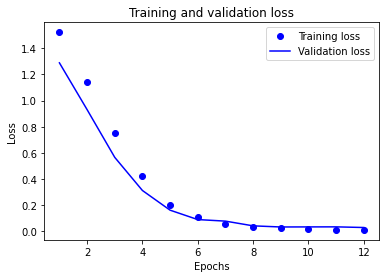

In [561]:
plt.figure()
history_dict = results.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [563]:
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(elem) for elem in y_pred]

print("Classification report: \n", classification_report(y_test-1, y_pred_classes))

ValueError: in user code:

    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_26 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 40)
